# Analysing Bias in Word Embeddings

This notebook demonstrates functionalities for exploring bias in word embeddings.

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import logging
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine
from pathlib import Path, PosixPath
from tqdm.notebook import tqdm
from collections import defaultdict
from utils.utils import *
from utils.wordlist import *

In /home/kaspar/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaspar/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaspar/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kaspar/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaspar/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [6]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 1 Loading newsaper metdata and word lists


### 1.1 Newspaper metadata
Load newspaper metadata

In [7]:
METADATA_PATH = "../../resources/Lijst_kranten_final.xlsx"
df_meta = pd.read_excel(METADATA_PATH,sheet_name="Sheet1",index_col=0)

### 1.2 Gender lexicons

Load word annotations based on querying the Woordenboek Der Nederlandse Taal (WDNT) for explicitly gendered words.

In [8]:
FEM_PATH = "../../resources/int_vrouw.xlsx"
fem = pd.read_excel(FEM_PATH,sheet_name='Sheet1',index_col=0)

In [9]:
MALE_PATH = "../../resources/int_man.xlsx"
male = pd.read_excel(MALE_PATH,sheet_name='Sheet1',index_col=0)

In [10]:
male.head()

,Trefwoord,Originele spelling,Woordsoort,Selecteer,monosemy,Betekenis
Woordenboek,,,,,,
WNT,omweg,OMWEG,znw.(m.),0,0.0,"Eigenlijk, in tweeledige toepassing."
WNT,onecht,ONECHT (I),"znw.(v.,m.)",0,0.0,"znw., oudtijds vr., thans m.; het mv. niet in..."
WNT,oom,OOM,znw.(m.),1,1.0,Eigenlijk: een broeder des vaders of der moed...
WNT,oorlam,OORLAM,"znw.(m.,o.)",1,1.0,"Eigenlijk, als persoonsnaam, en dan m."
WNT,oppasser,OPPASSER,znw.(m.),1,1.0,De persoon die het toezicht op iets houdt; oo...


We use both the `Trefwoord` and `Originele spelling`, we also exclude words that are too ambiguous.

In [11]:
male_words = [w.lower().split()[0] for w in male[male.monosemy==1].Trefwoord.values]
male_words = male_words + [w.lower().split()[0] for w in male[male.monosemy==1]["Originele spelling"].values]
male_words = set(male_words)
female_words = [w.lower().split()[0] for w in fem[fem.monosemy==1].Trefwoord.values]
female_words = female_words + [w.lower().split()[0] for w in fem[fem.monosemy==1]["Originele spelling"].values]
female_words = set(female_words)

2020-10-30 09:04:50,178 : INFO : NumExpr defaulting to 8 threads.


In [12]:
print(len(female_words),len(male_words))

340 237


Below we add some words harvested after a simple round of lexicon expansion.

In [13]:
female_words.update(fem_words_ext)
male_words.update(male_words_ext)

In [14]:
print("Total number of female words: ",len(female_words),"\nTotal number of male words: ",len(male_words))

Total number of female words:  524 
Total number of male words:  390


# 2. Plotting Bias over Time

## 2.1 Selecting facet (values)

Here we decide on the facets that we want to investigate. We first select the "dimension", this corresponds to columns in the metadata spreadsheet, which have been used as facet during training. The options are printed below

In [15]:
df_meta.columns[4:]

Index(['Politek', 'Source', 'Verspreidingsgebied', 'Plaats van uitgave',
       'Provincie', 'Zuil'],
      dtype='object')

In [16]:
FACET = "Politek" # "Politek"
FACET_VALUES = df_meta[FACET].unique()
FACET_VALUES

array(['Neutraal', 'Liberaal', nan, 'Sociaal-democratisch', 'Katholiek',
       'Protestant', 'Conservatief'], dtype=object)

Next, select the facet values. In this scenario we only look at catholic, liberal and protestant newspapers. The variable `root` should point to the folder where the models are stored.

In [17]:
#SELECTED_FACETS = ['Neutraal', 'Liberaal','Sociaal-democratisch', 'Katholiek','Protestant']

In [43]:
root =Path("/kbdata/Processed/Models/")

In [44]:
katholiek_models = select_model_by_facet_value('Katholiek',root=root)
liberaal_models = select_model_by_facet_value('Liberaal',root=root)
protestant_models = select_model_by_facet_value('Protestant',root=root)

We only include years for which have langauge models for all three political orientations.

In [45]:
years = sorted(set(katholiek_models).intersection(set(liberaal_models)).intersection(set(protestant_models)))
years

[1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895]

## 2.2 Creating a target word list

Unless you created a target word list (i.e. a set of words) for which we want to compute the gender bias. If you don't have one, you can create a small lexicon by exploring models trained on all newspapers data. Since the number of articles increases with years (more words for later years) the vector representations will be biased toward the later period. For this reason, you can also inspect a model trained on earlier data, balance the target word list a bit more over time. 

In [20]:
base_model = "/kbdata/Processed/Models/BaseModel-1800-1909.w2v.model"
base_model = Word2Vec.load(base_model)
print(base_model)

2020-10-30 09:05:04,878 : INFO : loading Word2Vec object from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model
2020-10-30 09:05:05,844 : INFO : loading wv recursively from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model.wv.* with mmap=None
2020-10-30 09:05:05,845 : INFO : loading vectors from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:05:06,038 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:05:06,039 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:05:06,039 : INFO : loading trainables recursively from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model.trainables.* with mmap=None
2020-10-30 09:05:06,040 : INFO : loading syn1neg from /kbdata/Processed/Models/BaseModel-1800-1909.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:05:06,234 : INFO : setting ignored attribute cum_table to None


Word2Vec(vocab=414769, size=300, alpha=0.025)


In [21]:
base_model_early = "/kbdata/Processed/Models/BaseModel-1800-1870.w2v.model"
model_early = Word2Vec.load(base_model_early)
print(model_early)

2020-10-30 09:05:07,104 : INFO : loading Word2Vec object from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model
2020-10-30 09:05:07,414 : INFO : loading wv recursively from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model.wv.* with mmap=None
2020-10-30 09:05:07,415 : INFO : loading vectors from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:05:07,489 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:05:07,490 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:05:07,490 : INFO : loading trainables recursively from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model.trainables.* with mmap=None
2020-10-30 09:05:07,491 : INFO : loading syn1neg from /kbdata/Processed/Models/BaseModel-1800-1870.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:05:07,565 : INFO : setting ignored attribute cum_table to None


Word2Vec(vocab=155879, size=300, alpha=0.025)


In [22]:
base_model.most_similar('emotie',topn=20)

/home/kaspar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-10-30 09:05:07,891 : INFO : precomputing L2-norms of word weight vectors


[('emoties', 0.8034723997116089),
 ('ontroering', 0.7343713045120239),
 ('tragiek', 0.6650913953781128),
 ('aandoening', 0.6574211120605469),
 ('ontroeringen', 0.6550807952880859),
 ('gewaarwording', 0.6503021717071533),
 ('sensaties', 0.6494277715682983),
 ('impressie', 0.6388396620750427),
 ('gewaarwordingen', 0.6378535628318787),
 ('gemoedsaandoening', 0.6322503685951233),
 ('opwinding', 0.6322292685508728),
 ('gemoedsaandoeningen', 0.6257733106613159),
 ('bekoring', 0.6254158020019531),
 ('gemoedsbeweging', 0.6205160021781921),
 ('bewogenheid', 0.6146096587181091),
 ('aandoeningen', 0.6076104044914246),
 ('matheid', 0.6052461862564087),
 ('gemoedsbewegingen', 0.6050035953521729),
 ('gejaagdheid', 0.6027995347976685),
 ('vroolijkheid', 0.5885056853294373)]

In [23]:
model_early.most_similar('emotie',topn=20)

/home/kaspar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-10-30 09:05:08,594 : INFO : precomputing L2-norms of word weight vectors


[('ontroering', 0.5324569940567017),
 ('gemoedsbeweging', 0.5104452967643738),
 ('opschudding', 0.5005029439926147),
 ('neerslagtigheid', 0.4948607087135315),
 ('opgewondenheid', 0.49011462926864624),
 ('ontsteltenis', 0.4736787974834442),
 ('agitatie', 0.46817201375961304),
 ('ongerustheid', 0.4422236680984497),
 ('fenfatie', 0.44116276502609253),
 ('aandoening', 0.4408707618713379),
 ('verflagenheid', 0.4402935206890106),
 ('gemoedsaandoening', 0.43809789419174194),
 ('onsteltenis', 0.4371126890182495),
 ('gisting', 0.43616414070129395),
 ('sensatie', 0.422627717256546),
 ('gisling', 0.41885924339294434),
 ('ontfteltenis', 0.40984198451042175),
 ('gewaarwording', 0.4068605899810791),
 ('aandoeningen', 0.4026297628879547),
 ('paniek', 0.39478182792663574)]

For demonstration purposes, we use the target list below, asking the question how gendered are emotions?

In [24]:
target_list = ["emotie","ontroering", "gemoedsbeweging", "opgewondenheid", "agitatie", 
                "aandoening", "gemoedsaandoening", "sensatie", "fenfatie",
               "emoties","ontroeringen","opwinding"]


In the cell below, we use the `compute_bias` function the calculate a bias score given "male" and "female" words together with a list of target tokens.



In [26]:
help(compute_bias)

Help on function compute_bias in module utils.utils:

compute_bias(p1:list, p2:list, target:list, model:gensim.models.word2vec.Word2Vec, metric:Callable[[list, list], float]=<function <lambda> at 0x7fc8f98b8ea0>) -> float
    Given two word lists that capture the bias dimension (e.g. gender male vs female) and
    a target word list (the concept for which we want to calculate the gender bias 
    (e.g. words related to emotion) this function returns a bias score by comparing
    the similarity between each target word with each of the pole words. The bias score 
    is the difference between averaged similarity scores for each pole. 
    Arguments:
        p1 (list): list of pole words
        p2 (list): lost of pole words
        target (list): list of target words
        model (gensim.models.word2vec.Word2Vec): a word2vec model
        metric (funtion): distance function, either cosine or euclidean
    Returns:
        bias score as float



The training functions allows you to train a model from scratch or finetune an existing model. If you want to use finetuned models for measuring bias, set `FINETUNED` flag to `True`, this substract a `base_bias` score from the biase scores produced by the finetuned models.

Computing the bias scores for all model, may take a few minutes.

In [35]:
FINETUNED = False

In [36]:
results = {}
if FINETUNED:
    base_bias = compute_bias(female_words,male_words,target_list,base_model)
else:
    base_bias = .0
    
for year in tqdm(years):
    lib_model = Word2Vec.load(str(liberaal_models[year]))
    lib_bias = compute_bias(female_words,male_words,target_list,lib_model) - base_bias
    kath_model = Word2Vec.load(str(katholiek_models[year]))
    kath_bias = compute_bias(female_words,male_words,target_list,kath_model) - base_bias
    protestant_model = Word2Vec.load(str(protestant_models[year]))
    protestant_bias = compute_bias(female_words,male_words,target_list,protestant_model) - base_bias
    results[year] = (lib_bias,kath_bias,protestant_bias)

2020-10-30 09:31:42,252 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model
2020-10-30 09:31:42,732 : INFO : loading wv recursively from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model.wv.* with mmap=None
2020-10-30 09:31:42,733 : INFO : loading vectors from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:31:44,280 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:31:44,281 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:31:44,281 : INFO : loading trainables recursively from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model.trainables.* with mmap=None
2020-10-30 09:31:44,282 : INFO : loading syn1neg from /kbdata/Processed/Models/1840-1860-Liberaal.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:31:45,887 : INFO : setting ignored attribute cum_table to None
2020-1

2020-10-30 09:32:00,484 : INFO : loading wv recursively from /kbdata/Processed/Models/1850-1870-Protestant.w2v.model.wv.* with mmap=None
2020-10-30 09:32:00,485 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:32:00,485 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1850-1870-Protestant.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:32:00,486 : INFO : loading trainables recursively from /kbdata/Processed/Models/1850-1870-Protestant.w2v.model.trainables.* with mmap=None
2020-10-30 09:32:00,486 : INFO : setting ignored attribute cum_table to None
2020-10-30 09:32:00,487 : INFO : loaded /kbdata/Processed/Models/1850-1870-Protestant.w2v.model
2020-10-30 09:32:00,570 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1855-1875-Liberaal.w2v.model
2020-10-30 09:32:01,060 : INFO : loading wv recursively from /kbdata/Processed/Models/1855-1875-Liberaal.w2v.model.wv.* with mmap=None
2020-10-30 09:32:01,061 : INFO : loading vectors from

2020-10-30 09:32:24,891 : INFO : loaded /kbdata/Processed/Models/1865-1885-Liberaal.w2v.model
2020-10-30 09:32:25,609 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model
2020-10-30 09:32:25,809 : INFO : loading wv recursively from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model.wv.* with mmap=None
2020-10-30 09:32:25,809 : INFO : loading vectors from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:32:27,137 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:32:27,138 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:32:27,138 : INFO : loading trainables recursively from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model.trainables.* with mmap=None
2020-10-30 09:32:27,139 : INFO : loading syn1neg from /kbdata/Processed/Models/1865-1885-Katholiek.w2v.model.trainables.syn1neg.np

2020-10-30 09:32:58,935 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1875-1895-Protestant.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:32:58,935 : INFO : loading trainables recursively from /kbdata/Processed/Models/1875-1895-Protestant.w2v.model.trainables.* with mmap=None
2020-10-30 09:32:58,936 : INFO : loading syn1neg from /kbdata/Processed/Models/1875-1895-Protestant.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:33:00,387 : INFO : setting ignored attribute cum_table to None
2020-10-30 09:33:00,388 : INFO : loaded /kbdata/Processed/Models/1875-1895-Protestant.w2v.model
2020-10-30 09:33:00,802 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1880-1900-Liberaal.w2v.model
2020-10-30 09:33:01,625 : INFO : loading wv recursively from /kbdata/Processed/Models/1880-1900-Liberaal.w2v.model.wv.* with mmap=None
2020-10-30 09:33:01,625 : INFO : loading vectors from /kbdata/Processed/Models/1880-1900-Liberaal.w2v.model.wv.vectors.npy

2020-10-30 09:33:49,048 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model
2020-10-30 09:33:49,436 : INFO : loading wv recursively from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model.wv.* with mmap=None
2020-10-30 09:33:49,436 : INFO : loading vectors from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:33:51,688 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:33:51,689 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:33:51,689 : INFO : loading trainables recursively from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model.trainables.* with mmap=None
2020-10-30 09:33:51,690 : INFO : loading syn1neg from /kbdata/Processed/Models/1890-1910-Katholiek.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:33:51,859 : INFO : setting ignored attribute cum_table to None


## Plotting the results

The cells below, plot the evolution of bias over time by the political leaning of the newspaper. Change the `FROM` to `TO` variables to adjust the period covered by the timeline.

In [40]:
FROM= 1850
TO = 1910

<AxesSubplot:>

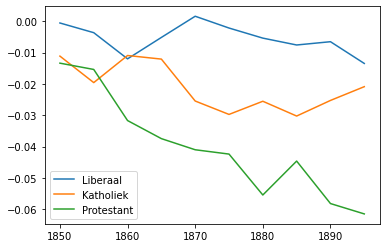

In [41]:
df_result = pd.DataFrame(results).T#.plot()
df_result.columns = ["Liberaal", "Katholiek", "Protestant"]
df_result.loc[FROM:TO].plot()

<AxesSubplot:>

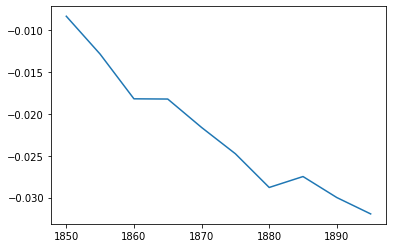

In [42]:
df_result["Average"] = df_result.mean(axis=1)
df_result["Average"].loc[FROM:TO].plot()

# 3. Inspect Bias Scores

The timelines give a sense of general historical tendencies. 
For emotion example, you'll notice that differences between `Katholiek` and `Liberaal` are actually not that substantive, which may come somewhat as a surprise.
To understand what is happening here, we can have a closer look at the what drives these bias scores, by inspecting which gender categories are portrayed as emotional.

For this we use the `inspect_bias` function.

In [50]:
help(inspect_bias)

Help on function inspect_bias in module utils.utils:

inspect_bias(p1:list, p2:list, target:list, model:gensim.models.word2vec.Word2Vec, metric:Callable[[list, list], float]=<function <lambda> at 0x7fc8eac7c510>) -> tuple
    this function allows you to inspect which terms have high bias scores
    applied to gender, it shows which men and women have a hight bias score for
    a given list of target words. the function maps each word in p1 and p2 to 
    a bias score comp
    Arguments:
        p1 (list): word list for first pole
        p2 (list): word list for the second pole
        target (list): word list for the target concept
        model (gensim.models.word2vec.Word2Vec): a word2vec model
        metric (function): a similarity metric
    Returns:
        a tuple with containing two dictionaries (for p1 and p2). each d
        dictionary maps indidividual words to the their bias scores



Change the `YEAR` variable to a period you want to investigate more closely.

## 3.1 Computing bias score for one selected year

In [55]:
YEAR = 1850

below we compute the gender bias in the liberal and katholiek models for that year.

In [51]:
lib_model = Word2Vec.load(str(liberaal_models[YEAR]))
lib_bias = inspect_bias(female_words,male_words,target_list,lib_model)
kath_model = Word2Vec.load(str(katholiek_models[YEAR]))
kath_bias = inspect_bias(female_words,male_words,target_list,kath_model)
protestant_model = Word2Vec.load(str(protestant_models[YEAR]))
protestant_bias = inspect_bias(female_words,male_words,target_list,protestant_model)

2020-10-30 09:42:51,328 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model
2020-10-30 09:42:51,557 : INFO : loading wv recursively from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model.wv.* with mmap=None
2020-10-30 09:42:51,558 : INFO : loading vectors from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 09:42:51,641 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 09:42:51,642 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model.vocabulary.* with mmap=None
2020-10-30 09:42:51,642 : INFO : loading trainables recursively from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model.trainables.* with mmap=None
2020-10-30 09:42:51,643 : INFO : loading syn1neg from /kbdata/Processed/Models/1850-1870-Liberaal.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 09:42:51,739 : INFO : setting ignored attribute cum_table to None
2020-1

## 3.2 Plotting the distribution of bias scores

As said in the docstring, `inspect_bias` returns a tuple containing two dictionaries. Each of them maps individual words to their bias scores.

In [56]:
list(kath_bias[0].items())[:10]

[('dienstmeid', 1.2565392507240176),
 ('bees', -0.39814979769289494),
 ('juffer', 1.0591034702956676),
 ('dienstbode', 1.3158989269286394),
 ('baronnes', 0.7410836424678564),
 ('vischvrouw', 1.148152084555477),
 ('mama', 1.245691875461489),
 ('voogdes', -0.25411135237663984),
 ('meid', 1.1846056897193193),
 ('jodin', 0.894903153181076)]

We can now plot the distribution of bias by gender. Below we plot the scores for female (`lib_bias[0]`, blue line) and male (`lib_bias[1]`, orange line) words in the liberal model.

<AxesSubplot:ylabel='Density'>

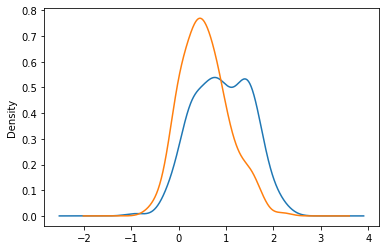

In [59]:
pd.Series(list(lib_bias[0].values())).plot(kind='density')
pd.Series(list(lib_bias[1].values())).plot(kind='density')

The plot below compares the distribution of bias scores for female words between the katholiek (blue line) and liberal model (orange line)

<AxesSubplot:ylabel='Density'>

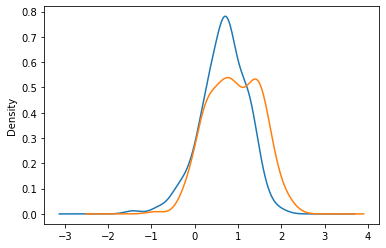

In [61]:
pd.Series(list(kath_bias[0].values())).plot(kind='density')
pd.Series(list(lib_bias[0].values())).plot(kind='density')

<AxesSubplot:ylabel='Density'>

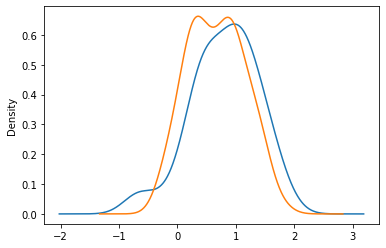

In [62]:
pd.Series(list(protestant_bias[0].values())).plot(kind='density')
pd.Series(list(protestant_bias[1].values())).plot(kind='density')

# 3.3 Inspecting the most (or least) biased words

Besides plotting the distribution, we can also inspect the most (or least) biased words running the cells below.

The ten most biased female words in the liberal model.

In [65]:
sorted(lib_bias[0].items(),key=lambda x: x[1],reverse=True)[:10]

[('brunette', 2.297665663063526),
 ('kunstenares', 2.171439327299595),
 ('kamenier', 2.1621857807040215),
 ('buurvrouw', 2.060928963124752),
 ('somnambule', 2.010161869227886),
 ('gezellin', 1.9951301217079163),
 ('dienstmaagd', 1.980964258313179),
 ('dame', 1.9173139687627554),
 ('slavin', 1.8965954706072807),
 ('martelares', 1.8692283928394318)]

The ten most biased male words in the catholic model.

In [66]:
sorted(kath_bias[1].items(),key=lambda x: x[1],reverse=True)[:10]

[('wereld', 1.5526563115417957),
 ('grijsaard', 1.3624730275478214),
 ('woesteling', 1.3007169005722972),
 ('monnik', 1.1934383944608271),
 ('verloofde', 1.1431697686202824),
 ('denker', 1.1032027378678322),
 ('kerel', 1.0898987799882889),
 ('bokser', 1.0407800041139126),
 ('gendarme', 1.0228835102170706),
 ('jongen', 1.0223372471518815)]

The ten most biased female words in the catholic model.

In [67]:
sorted(kath_bias[0].items(),key=lambda x: x[1],reverse=True)[:10]

[('gezellin', 1.9895132407546043),
 ('bedelares', 1.788897842168808),
 ('kamenier', 1.59621412307024),
 ('dame', 1.582260675728321),
 ('buurvrouw', 1.5795261561870575),
 ('dienstmaagd', 1.5729063525795937),
 ('vorstin', 1.5116195119917393),
 ('schoonmoeder', 1.4297476336359978),
 ('moedor', 1.3971776380203664),
 ('kunstenares', 1.3876029551029205)]

# 4. Plotting Facets

The section of the notebook provides some function to zoom in on differences between facets (such as politics or province) for a given year.

In [74]:
FACET = "Provincie" # "Politek" | Provincie
FACET_VALUES = df_meta[FACET].unique()
FACET_VALUES

array(['Noord Holland', 'Gelderland', 'Groningen', 'Friesland', 'Drenthe',
       'Zeeland', 'North Brabant', 'South Holland', 'Overijssel',
       'Utrecht', 'Limburg'], dtype=object)

In [75]:
YEAR = 1880

selected_models = {}

for facet in FACET_VALUES:
    model_paths = select_model_by_facet_value(facet)
    
    selected_models[facet] = model_paths.get(YEAR,None)
    
selected_models = {w:v for w,v in selected_models.items() if v}

In [76]:
selected_models

{'Noord Holland': PosixPath('/kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model'),
 'Gelderland': PosixPath('/kbdata/Processed/Models/1880-1900-Gelderland.w2v.model'),
 'Groningen': PosixPath('/kbdata/Processed/Models/1880-1900-Groningen.w2v.model'),
 'Friesland': PosixPath('/kbdata/Processed/Models/1880-1900-Friesland.w2v.model'),
 'Zeeland': PosixPath('/kbdata/Processed/Models/1880-1900-Zeeland.w2v.model'),
 'North Brabant': PosixPath('/kbdata/Processed/Models/1880-1900-North Brabant.w2v.model'),
 'South Holland': PosixPath('/kbdata/Processed/Models/1880-1900-South Holland.w2v.model'),
 'Overijssel': PosixPath('/kbdata/Processed/Models/1880-1900-Overijssel.w2v.model')}

In [77]:
results = {}
for w,v in tqdm(selected_models.items()):
    model = Word2Vec.load(str(v))
    results[w] = compute_bias(female_words,male_words,target_list,model)

2020-10-30 10:06:23,793 : INFO : loading Word2Vec object from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model
2020-10-30 10:06:24,404 : INFO : loading wv recursively from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model.wv.* with mmap=None
2020-10-30 10:06:24,405 : INFO : loading vectors from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model.wv.vectors.npy with mmap=None
2020-10-30 10:06:24,576 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 10:06:24,577 : INFO : loading vocabulary recursively from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model.vocabulary.* with mmap=None
2020-10-30 10:06:24,577 : INFO : loading trainables recursively from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model.trainables.* with mmap=None
2020-10-30 10:06:24,578 : INFO : loading syn1neg from /kbdata/Processed/Models/1880-1900-Noord Holland.w2v.model.trainables.syn1neg.npy with mmap=None
2020-10-30 10:06:24,863 : INFO : setting ignored attr

<AxesSubplot:>

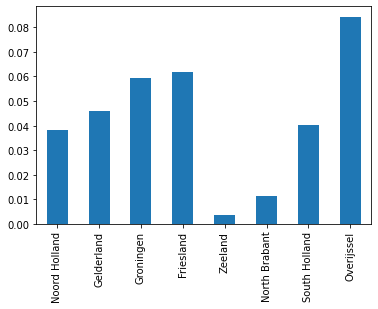

In [78]:
pd.Series(results).plot(kind='bar')

# Fin.